In [12]:
import pandas as pd
df = pd.read_csv("C:\\Users\\VICTUS\\Documents\\GitHub\\ppcc_dgfuchile\\eventos\\2024-04-30.csv")
df.drop(['pp', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df.head()
df.index.name = 'index'
df.to_csv("C:\\Users\\VICTUS\\Documents\\GitHub\\ppcc_dgfuchile\\usuarios\\usuarios.csv")


,nombre,mail,comuna,lat,lon,alias,grupo
0,Vicente López,vicentelopez.v@gmail.com,Peñaflor,-33.606575,-70.906942,Huaso,MET-01
1,Maria Fernanda Ruedlinger,maria.ruedlinger@ug.uchile.cl,Maipu,-33.491232,-70.766251,Saturno,MET-01
2,María Victoria Atisha,maria.atisha@ug.uchile.cl,Ñuñoa,-33.460082,-70.592846,Botitas,MET-01
3,Diego Ignacio Faúndez,dfaundezortega@gmail.com,La Florida,-33.534556,-70.550194,Fortnite,MET-01
4,Matías Valentín Guzmán,matias.guzmanparra@gmail.com,La Florida,-33.531720,-70.556389,KIKE,MET-01


In [8]:
import pandas as pd
df = pd.read_csv("C:\\Users\\VICTUS\\Documents\\GitHub\\ppcc_dgfuchile\\eventos\\2023-07-21.csv")
df.index.name = 'index'

pp = df.pp.values

df.drop(['pp'], axis=1, inplace=True)
df['pp'] = pp
df

df.to_csv("C:\\Users\\VICTUS\\Documents\\GitHub\\ppcc_dgfuchile\\eventos\\2023-07-21.csv")

In [7]:
import pandas as pd
df = pd.read_csv(".\\usuarios\\usuarios.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index('index', inplace=True)
df.to_csv(".\\usuarios\\usuarios.csv")

---

In [288]:
import os
import time
import requests
import pandas as pd

def vismet_makerequest(url, count=0):
    """
    hace el request al servidor, si el request falla lo intenta de nuevo
    hasta 5 veces. Si falla 5 veces seguidas tira error
    """
    if count>5:
        raise RuntimeError('Servidor no responde !!')
    response = requests.get(url)
    if response.status_code == 200:
        return response
    else:
        time.sleep(1)
        count += 1
        print('Server didnt answer, trying again\nAttempt:', count)
        return vismet_makerequest(url, count=count)

def vismet_parse_bytes(content, latmin=-35, latmax=-32):
    """
    Lee el contenido de la respuesta del servidor (bytes) y lo 
    transforma a un dataframe con la data de las estaciones
    """
    with open('tmp.csv', 'bw+') as csv:
        csv.write(content)
        csv.close()
    data = pd.read_csv('tmp.csv', index_col=0)
    data = data[['Nombre','Organización','Latitud','Longitud','Valor']]
    data.columns  = ['nombre','grupo','lat','lon','pp']
    data['alias'] = data.nombre+' - '+data.grupo.map(lambda st: st.upper())
    
    data = data.sort_values(by='lat', ascending=False)
    data = data[data.lat<latmax]
    data = data[data.lat>latmin]
    os.system('rm -f tmp.csv')
    return data

def vismet_download(itime, ftime, basetime='1970-01-01 20:00:00'):
    """
    descarga la data entre dos fechas y devuelve un dataframe con la info
    """
    # definir url
    url      = 'https://vismet.cr2.cl/api/measure/by-measure-type/1/'
    opts     = 'by-timestamp/{}/by-interval/1/sum/csv'
    basetime = pd.to_datetime(basetime)
    
    # guardar data para cada tiempo descargado
    data     = []
    timestamps = pd.date_range(itime, ftime, freq='h')[1:]
    for time in timestamps:
        dt = int((time-basetime).total_seconds())
        url_tmp  = url+opts.format(dt) # fijar el url
        response = vismet_makerequest(url_tmp) # hacer el request
        data.append(vismet_parse_bytes(response.content)) #guardar
    data = pd.concat(data, keys=timestamps) #concatenar en el tiempo
    data = data.unstack(0).T.unstack(1).T # reordenar tabla
    return data

def vismet_qqcc_data(data, null_cut):
    """
    devuelve una mascara con las estaciones q midieron menos del 'null_cut' %
    del evento (en fraccion)
    """
    time      = data.index.get_level_values(1).unique()
    null_perc = 1-data['pp'].isnull().groupby(level=0).sum()/len(time)
    mask      = null_perc>null_cut
    return mask

def vismet_postprocess_data(data, null_cut):
    """
    se aplica el control de calidad a los montos acumulados en el tiempo
    se calcula el monto acumulado para el evento y devuelve un dataframe
    con el emismo formato que el .csv de los pluviometors ciudadanos.
    """
    # control de calidad
    mask  = vismet_qqcc_data(data, null_cut)
    data  = data.loc[mask[mask].index]
    
    # calcular el acumulado del evento
    ndata = []
    for sid in data.index.get_level_values(0).unique():
        station_data  = data.loc[sid]
        station_mdata = station_data.iloc[0,:]
        station_pp    = station_data['pp'].sum()
        
        station_data = station_mdata.copy().drop('pp')
        station_data.name = sid
        station_data['pp'] = station_pp
        
        ndata.append(station_data)     
    return pd.concat(ndata, axis=1).T

<Axes: xlabel='lat'>

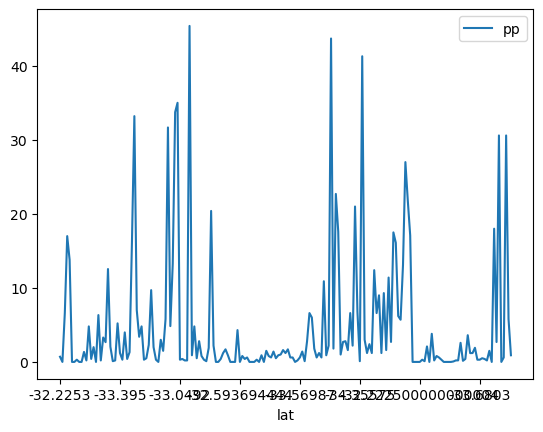

In [287]:
# Ejemplo de uso
# <- Hace el request y devuelve dataframe con todas las estaciones y montos acumulados cada una hora
vismet_data = vismet_download('2022-07-13','2022-07-15')
# <- Quita estaciones que tienen menos del 80% de los datos para el período escogido. Devuelve el acumulado entre las fechas escogidas.
vismet_data = vismet_postprocess_data(vismet_data, 0.8)  

vismet_data.plot(x='lat', y='pp')